In [1]:
import pandas as pd
import numpy as np
import sklearn

In [ ]:
#for colab reading files
path = 'drive/My Drive/Projects/EHR_record/'


In [2]:
path=""

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [89]:
demographic_train = pd.read_csv(path+'Train/demographics.csv')
labs_train = pd.read_csv(path+'Train/labs.csv')
vitals_train = pd.read_csv(path+'Train/vitals.csv')

In [ ]:
demographic_test = pd.read_csv(path+'Test/demographics.csv')
labs_test = pd.read_csv(path+'Test/labs.csv')
vitals_test = pd.read_csv(path+'Test/vitals.csv')

## 1. Exloratory analysis

In [ ]:
def perform_eda(dataframes, names):
    for df, name in zip(dataframes, names):
        print(f"EDA for {name}:")
        print(df.describe())
        print(f"Size of {name}:", df.shape)
        print(f"Null values in {name}:\n", df.isnull().sum())
        print("\n")

# Usage:
dataframes = [demographic_train, labs_train, vitals_train]
names = ["demographic", "labs", "vitals"]
perform_eda(dataframes, names)


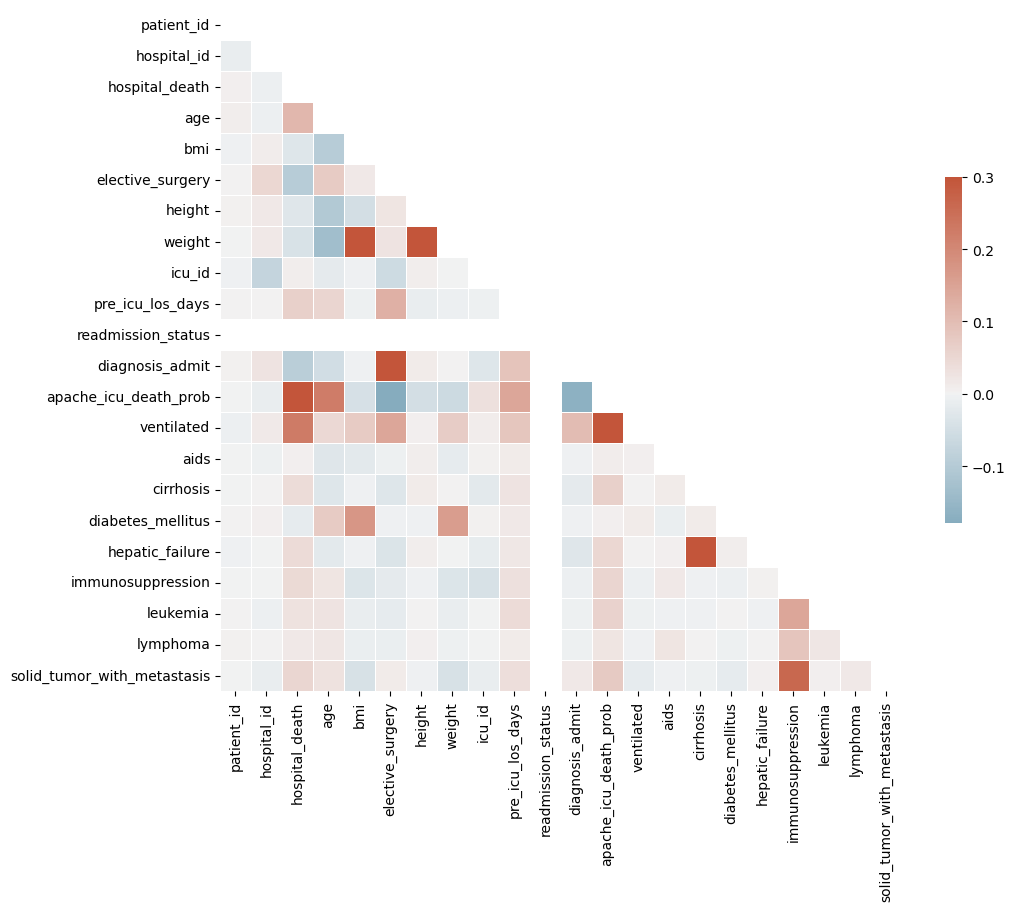

In [43]:
#Check the linearality of predictors in demographic
import seaborn as sns
import matplotlib.pyplot as plt

# Get numerical features
numerical_features = demographic_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Compute the correlation matrix
corr = demographic_train[numerical_features].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.savefig('correlation graph.png')
plt.show()

In [93]:

def demographic_fill_na(df):
    # Weight and bmi and height are highly related, remove weight.
    df.drop('weight', axis=1, inplace=True)

    # Fill the null value in ethnicity column with "Other/Unknown"
    df['ethnicity'] = df['ethnicity'].fillna('Other/Unknown')

    #Fill the null value of gender with equal M and F
    # Define the choices and probabilities
    choices = ['M', 'F']
    probabilities = [0.5, 0.5]

    # Use np.random.choice to fill each missing value
    df.loc[df['gender'].isnull(), 'gender'] = np.random.choice(choices, size=df['gender'].isnull().sum(), p=probabilities)
    
    # Fill the null value in "hospital_admit_source" column with "Unknown"
    df['hospital_admit_source'] = df['hospital_admit_source'].fillna('Unknown')
    
    # Fill the null value in "icu_admit_source" column with "Floor"
    df['icu_admit_source'] = df['icu_admit_source'].fillna('Floor')

    # Fill the null value in "bodysystem_diagnosis_admit" column with "Unknown"
    df['bodysystem_diagnosis_admit'] = df['bodysystem_diagnosis_admit'].fillna('Unknown')
    return df

# remove unit of measure in labs and vitals, the unit of measure shouldn't have any predict power
def labs_process(labs):
    #remove unit of measure
    labs.drop('Unit of Measure', axis=1, inplace=True)
    #pivot table to get unique patient_id
    labs_pivot = labs.pivot_table(
        values=['Min Value', 'Max Value'],
        index='patient_id',
        columns=['Lab', 'Time of Measure (First Day or First Hour of Stay)']
    )
    print(labs_pivot.columns)
    labs_pivot.reset_index(inplace=True)
    print(labs_pivot.columns)
    labs_pivot.columns = ['patient_id' if col[0] == 'patient_id' else '_'.join(str(col).strip() for col in col) for col in labs_pivot.columns]
    return labs_pivot

# It's the very similar function as labs_process
def vitals_process(vitals):
    #remove unit of measure
    vitals.drop('Unit of Measure', axis=1, inplace=True)
    #pivot table to get unique patient_id
    vitals_pivot = vitals.pivot_table(
        values=['Min Value', 'Max Value'],
        index='patient_id',
        columns=['Vital', 'Time of Measure (First Day or First Hour of Stay)']
    )
    vitals_pivot.reset_index(inplace=True)
    print(vitals_pivot.columns)
    vitals_pivot.columns = ['patient_id' if col[0] == 'patient_id' else '_'.join(str(col).strip() for col in col) for col in vitals_pivot.columns]
    return vitals_pivot


In [94]:
# Define merge dataset function
def merge_datasets(df1, df2, df3, key):

    merged_df = pd.merge(df1, df2, on=key, how='inner')
    merged_df = pd.merge(merged_df, df3, on=key, how='inner')
    return merged_df

In [95]:
train = merge_datasets(demographic_train,vitals_train,labs_train,'patient_id')
#test = merge_datasets(demographic_test,vitals_test,labs_test,'patient_id')
y_train = train['hospital_death']
X_train = train.drop('hospital_death', axis=1)


In [98]:
X_train.shape

(61598, 112)

## 2. Data cleaning

In [7]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

3. Fit on models

In [11]:
%pip install wandb

Note: you may need to restart the kernel to use updated packages.


In [12]:
import wandb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import classification_report

import seaborn as sns
import matplotlib.pyplot as plt

In [99]:
# Get numerical features
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Get categorical features
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()


# Define the preprocessing steps with all pipeline
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine numerical and categorical preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define the pipelines to try
pipelines = [
    {"name": "Logistic Regression", "pipeline": Pipeline([('preprocessor', preprocessor),
                                                          ('classifier', LogisticRegression(class_weight='balanced'))]),
                                                            "params_grid": logistic_params},
   {"name": "Random Forest", "pipeline": Pipeline([('preprocessor', preprocessor),
                                                   ('classifier', RandomForestClassifier())]),
                                                    "params_grid": rf_params},

    {"name": "Gradient Boost", "pipeline": Pipeline([('preprocessor', preprocessor),
                                                     ('classifier', GradientBoostingClassifier())]),
                                                     "params_grid": gb_params},

]


In [100]:
from sklearn.model_selection import RandomizedSearchCV

# Logistic Regressy hyperparamerters
logistic_params = {
    'classifier__max_iter': [1000, 5000, 10000]
}


# Random Forest hyperparameters
rf_params = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Gradient Boosting hyperparameters
gb_params = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__max_depth': [3, 5, 7]
}



# Define the fractions to try
fractions = [0.1, 0.2, 0.3]

# Define scoring dictionary
scoring = {
    'precision': 'precision',
    'recall': 'recall',
    'f1_score': 'f1'
}

In [101]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, auc


In [102]:

from sklearn.model_selection import GridSearchCV

# Helper function to fit the model with error handling
def fit_model(pipeline_dict, X_train, y_train):
    try:
        grid_search = GridSearchCV(pipeline_dict['pipeline'], pipeline_dict.get('params_grid', {}),
                                   cv=5, scoring=scoring, refit='f1_score')
        grid_search.fit(X_train, y_train)
        return grid_search
    except Exception as e:
        error_message = f"An error occurred while fitting the model {pipeline_dict['name']}: {e}"
        print(error_message)
        wandb.log({"error": error_message}) # Logging the error to W&B
        return None

# Helper function to evaluate the model with error handling
def evaluate_model(grid_search, X_val, y_val, model_name, fraction):
    if grid_search is None:
        error_message = f"Skipping evaluation for {model_name} due to an error during fitting."
        print(error_message)
        wandb.log({"error": error_message}) # Logging the error to W&B
        return

    try:
        y_pred = grid_search.predict(X_val)
        y_prob = grid_search.predict_proba(X_val)[:, 1]
        cm = confusion_matrix(y_val, y_pred)
        fpr, tpr, _ = roc_curve(y_val, y_prob)
        roc_auc = auc(fpr, tpr)
        log_results(grid_search, cm, fpr, tpr, roc_auc, model_name, fraction)
    except Exception as e:
        error_message = f"An error occurred while evaluating the model {model_name}: {e}"
        print(error_message)
        wandb.log({"error": error_message}) # Logging the error to W&B

def log_results(grid_search, cm, fpr, tpr, roc_auc, model_name, fraction):
    """Log results to W&B, including confusion matrix, ROC curve, and feature importances."""
    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f"Confusion Matrix for {model_name} with fraction {fraction}")
    confusion_matrix_image = plt.gcf()
    plt.close()

    # Plot ROC curve
    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name} with fraction {fraction}')
    plt.legend(loc="lower right")
    roc_curve_image = plt.gcf()
    plt.close()

    # Log the results
    wandb.log({
        "model_name": model_name,
        "best_params": grid_search.best_params_,
        "best_score": grid_search.best_score_,
        "confusion_matrix": wandb.Image(confusion_matrix_image),
        "roc_curve": wandb.Image(roc_curve_image),
        "precision": grid_search.cv_results_['mean_test_precision'].mean(),
        "recall": grid_search.cv_results_['mean_test_recall'].mean(),
        "f1_score": grid_search.cv_results_['mean_test_f1_score'].mean(),
        "fraction": fraction
    })


def train_and_evaluate(pipelines, fractions, train_data):
    # Initialize W&B
    wandb.init(project="EHR_record")

    # Loop over the pipelines and fractions
    for pipeline_dict in pipelines:
        for fraction in fractions:
            print(f"Training {pipeline_dict['name']} with fraction {fraction}")
            X_sampled, y_sampled = sample_data(train_data, fraction)
            X_train, X_val, y_train, y_val = train_test_split(X_sampled, y_sampled, test_size=0.2)

            # Fit the model
            grid_search = fit_model(pipeline_dict, X_train, y_train)

            # Evaluate the model
            evaluate_model(grid_search, X_val, y_val, pipeline_dict['name'], fraction)



In [ ]:

#Train and evaluate model
train_and_evaluate(pipelines, fractions, train)

best_score,▁▁▁
f1_score,▁▁▁
fraction,▁▄█
precision,▁▁▁
recall,▁▁▁
best_score,1.0
f1_score,1.0
fraction,0.3
model_name,Random Forest
precision,1.0
recall,1.0


Training Logistic Regression with fraction 0.1
Training Logistic Regression with fraction 0.2
Training Logistic Regression with fraction 0.3
Training Random Forest with fraction 0.1
